In [1]:
import Pkg
Pkg.activate("../src/FE_v0.1/Project.toml")

# using Pkg; Pkg.add("Measures")
# using Pkg; Pkg.add("JLD2")
# Pkg.add("FiniteElements")

import OrdinaryDiffEq as ODE

using QuadGK
using BasicBSpline
using Random
using Distributions
using LaTeXStrings
using Plots #, CairoMakie
using PyPlot
using Printf
using SparseArrays

using FiniteElements
using Base.Threads
using Plots.PlotMeasures
using Statistics

using LinearAlgebra # identity matrix
using Turing # sampling package
using StatsPlots
using StatsBase # for defining customized distributions 
using Optim # for ML and MAP estimation 
using AdaptiveMCMC # for using adaptive MCMC sampling
using ProgressMeter # to use progress track for sampling
using Dates # to measure computational time 
using FlexiMaps # Provide flexible mapping functionalities, particularly useful for data processing tasks

using JLD2 # to save results and reuse them
using Measures

include("../src/SIACMatrix_v2.jl")
include("../src/FE_v0.1/src/DG.jl")

results_dir = "results_section_6_2"

  Activating project at `~/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/src/FE_v0.1`
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


"results_section_6_2"

In [2]:
# Setting up Domain Parameters
xL = -1.0       # Left Domain Boundary
xR = 1.0        # Right Domain Boundary

# Setting up the Mesh-series
# IMPORTANT: For now need numEl>=10 for the base mesh, to construct SIAC matrix!!
pMax = 3            # largest polynomial degree used (sets up DG approximation with degree 1:pMax)
refine = 4          # Number of meshes (refine=1 means the base mesh is refined once, and there are two meshes)
numEl = 3*pMax+1    # Number of Elements in Base Mesh (Choosen such that on each mesh, the filter crosses the Boundary at max once)


mesh = Array{FiniteElements.Mesh}(undef, refine) # Mesh Data structure

# Mesh Info
dim = 1
ElemsPerDim = [numEl]
mesh_vertices = [xL xR]

# Creating the meshes
for m=1:refine
    mesh[m] = build_cube_mesh(mesh_vertices, ElemsPerDim*(2^(m-1)), dim)
end

In [3]:
# Initial Condition
u0(x) = 1 + .5*sin.(pi*x) # + 0.3*cos(pi*x) - 0.4*sin(2pi*x)

# Evaluation Nodes, for which the SIAC MAtrix is constructed
Nodes = Array{Array{Float64}}(undef,refine,pMax)        # Global evaluation Points 
w_Nodes_global = Array{Array{Float64}}(undef,refine,pMax)        # Global Quadrature Weigths
Nodes_loc = Array{Array{Float64}}(undef,refine,pMax)    # Local Evaluation points
w_Nodes_local = Array{Array{Float64}}(undef,refine,pMax)        # Local Quadrature Weigths
numNodes = zeros(Int,refine,pMax)     # number of evaluation points 


xEval = Array{Array{Float64}}(undef,refine,pMax)        # Global evaluation Points 
w_global = Array{Array{Float64}}(undef,refine,pMax)        # Global Quadrature Weigths
xEval_loc = Array{Array{Float64}}(undef,refine,pMax)    # Local Evaluation points
w_local = Array{Array{Float64}}(undef,refine,pMax)        # Local Quadrature Weigths
nEval = zeros(Int,refine,pMax)     # number of evaluation points 

# Available Node types:
# "GLeg"    Gauss-Legendre nodes
# "GLob"    Gauss-Lobatto nodes
# "uni"     Equidistant nodes
# "L2"      no Interpolation, chooses L2_projection
EvalType = "L2"   


# Setting up DoF handles, for Mesh series and different polynomial degrees
uh = Array{FE}(undef, refine, pMax)     # DG data structure

# Declaring Evaluation handles
# uh_ev and u0_ev evaluate uh and u at the points prescribed in xEval.
u0_ev =  Array{Vector}(undef,refine,pMax)   # True solution (for different refinements and degrees)
uh_Nodal = Array{Vector}(undef,refine,pMax)    # DG Initial Condition (for different refinements and degrees)
uh_ev = Array{Vector}(undef,refine,pMax)    # DG Initial Condition (for different refinements and degrees)
uh_ev_pp = Array{Vector}(undef,refine,pMax) # DG Initial Condition, SIAC filtered (for different refinements and degrees)


# SIAC Matrices
F  = Array{Matrix}(undef,refine,pMax)
F_ev  = Array{Matrix}(undef,refine,pMax)

# Initializing Evaluation handles, IC and SIAC matrices
for m=1:refine
    for p=1:pMax

        if EvalType=="L2"
            Nodes[m,p], w_global[m,p], Nodes_loc[m,p], w_local[m,p] = makeNodes(mesh[m], p, type="GLeg") # Gauss-Legendre Evaluation nodes
            numNodes[m,p] = length(Nodes[m,p])

            xEval[m,p], ~, xEval_loc[m,p], ~ = makeNodes(mesh[m], 10, type="GLeg") # Gauss-Legendre Evaluation nodes
            nEval[m,p] = length(xEval[m,p])


            uh[m,p] = L2(u0, mesh[m], p, dim)
        else
            Nodes[m,p], w_global[m,p], Nodes_loc[m,p], w_local[m,p] = makeNodes(mesh[m], p, type=EvalType) # Nodes
            numNodes[m,p] = length(Nodes[m,p])

            xEval[m,p], ~, xEval_loc[m,p], ~ = makeNodes(mesh[m], 10, type="GLeg") # Gauss-Legendre Evaluation nodes
            nEval[m,p] = length(xEval[m,p])


            uh[m,p] =  Interpolate(u0, mesh[m],xEval_loc[m,p], p, dim)
        end

        uh_Nodal[m,p] = [evalFE(Nodes[m,p][j],uh[m,p]) for j=1:numNodes[m,p]]

        uh_ev[m,p] = [evalFE(xEval[m,p][j],uh[m,p]) for j=1:nEval[m,p]]
        u0_ev[m,p] = [u0(xEval[refine,pMax][j]) for j=1:nEval[refine,pMax]]

        # Initializing the SIAC matrices
        # F[m,p] is a quadratic matrix, used to postprocess uh_ev[m,p]
        # boundaryTreatment="none"      : Default, leaves near-boundary region unchanged
        # boundaryTreatment="periodic"  : Assumes periodic boundary
        F[m,p] = global_SIAC_Mat(p, mesh[m].NC[], Nodes_loc[m,p], Nodes_loc[m,p]; boundaryTreatment="periodic")    # square SIAC Matrix 
        F_ev[m,p] = global_SIAC_Mat(p, mesh[m].NC[], Nodes_loc[m,p], xEval_loc[m,p]; boundaryTreatment="periodic") # Evaluation SIAC Matrix
        uh_ev_pp[m,p] =  F_ev[m,p]*uh_Nodal[m,p]  # SIAC Filtered IC

    end
end

Projecting Data... 100%|█████████████████████████████████| Time: 0:00:00


In [4]:
# Evaluation Handles
globalDoFs = Array{Vector}(undef, refine, pMax)         # Stores the DoF of the IC. globalDoFs[m,p] are the DoFs of uh[m,p], used for time stepping
discretization = Array{Function}(undef, refine, pMax)   # The spatial (DG) discretization

# Evaluation stuff
globalDoFs_final = Array{Vector}(undef, refine, pMax)   # Stores the DoF of the final state. 
uh_Nodal_final = Array{Vector}(undef,refine,pMax)          # Evaluation points for the final state 

uh_ev_final = Array{Vector}(undef,refine,pMax)          # Evaluation points for the final state 
uh_ev_final_pp = Array{Vector}(undef,refine,pMax)       # Evaluation points for the final state 


# define the Advection velocity
alpha = [1.0]  # Advection velocity

# Declare Discretization of differential operators
M_fac = Array{Union{Diagonal{Float64, SparseVector{Float64,Int}},Factorization}}(undef, refine, pMax)        # Factorized Mass Matrix
A = Array{Matrix}(undef, refine, pMax)          # Advection + Boundary Matrix

# Assembling the spatial discretization
for m=1:refine
    for p=1:pMax

        # Uncomment to reinitialize DG-handles
        if EvalType=="L2"
            uh[m,p] = L2(u0, mesh[m], p, dim)
        else
            uh[m,p] =  Interpolate(u0, mesh[m],xEval_loc[m,p], p, dim)
        end

        # Get DoFs from DG-handle
        globalDoFs[m,p] = getDoF(uh[m,p])
        
        M = assemble_BilinearForm(uh[m,p],dim,"Base_Base")             # Mass Matrix
        K = assemble_BilinearForm(uh[m,p],dim,"Grad_Base",field=alpha) # Advection Matrix

        # (periodic) Outlet/do-nothing BC
        Bd = assembleBoundaryMatrix(uh[m,p], 2, dim) # Outlet 

        # Discrtization Matrix + factorization
        A[m,p] = (K-Bd)
        M_fac[m,p] = factorize(M)

        # Discretized PDE
        discretization[m,p] = (dummyDoF,ts) -> M_fac[m,p]\(A[m,p]*dummyDoF + prescribeBoundaryData(uh[m,p], 1, dim, x->u0(x-ts); field=alpha))
    end
end

Assembling Advection Matrix (Face Contribution).. 100%|██| Time: 0:00:00


In [5]:
# Set final time
t_end = 1.0

1.0

In [6]:
# check results stored before
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r") do file
    println("Variables stored in the file:")
    println(keys(file))
end

Variables stored in the file:
["uh_ev_final", "uh_Nodal_final", "uh_ev_final_pp", "h_ref", "err", "err_pp", "fx_BCD", "err_BCD"]


In [7]:
# Load results
@load joinpath(results_dir, "results_DG_T1.jld2") uh_ev_final uh_Nodal_final

2-element Vector{Symbol}:
 :uh_ev_final
 :uh_Nodal_final

In [8]:
nr_chains = 4 # number of chains to sample, corresponding to the threads

4

In [9]:
function init_rand_func(F, fx_noisy, R, c, d, init::String)
    N = size(F, 2)
    
    # Choose an initialization for the MCMC chains 
    init_param = Array{Float64}(undef, N+2, nr_chains)

    # Use random initializations 
    if init=="random"
        
        ## Genrate random samples from the original prior 

        # Set-up an array for the initializations 
        initial_random = Array{Float64}(undef, N+2, nr_chains)

        # Generate α- and β-samples from the gamma distribution
        α_random = rand(Gamma(c, 1/d), nr_chains)
        β_random = rand(Gamma(c, 1/d), nr_chains)

        # Get corresponding u-sample by performing an x-update 
        u_random = Array{Float64}(undef, N, nr_chains)
        for j in 1:nr_chains
            α = α_random[j]
            β = β_random[j]
            C_inv = sparse(α*F'*F + β*R'*R)  # update covariance matrix
            u_random[:,j] = C_inv \ (α*F'*fx_noisy)  # update the mean
        end

        # Collect the α-, β-, and u-samples
        for j in 1:nr_chains
            initial_random[1:end-2,j] .= u_random[:,j]
            initial_random[end-1,j] = α_random[j]
            initial_random[end,j] = β_random[j]
        end

        init_param = initial_random

        # # Use MAP estimate 
        # elseif init=="MAP"
        #     # Select the initial set of parameters 
        #     for j in 1:nr_chains 
        #         init_param[:,j] = fx_MAP_tmp
        #     end

        else
            error("Invalid initialization option provided: $init. Please choose either 'MAP' or 'random'.")
    end

    return init_param 
end

init_rand_func (generic function with 1 method)

In [10]:
# Define the Gibbs sampling function
function gibbs_sampler(init, y, F, R, c, d, iterations)
    N = size(F, 2)  # Number of elements in u
    m = size(y, 1)  # Length of observed data y

    Ft = transpose(F)
    Rt = transpose(R)
    FtF = Ft*F
    RtR = Rt*R
    Fty = Ft*y

    # Initialize latent variables and parameters
    u = init[1:end-2]  # Initial guess for u
    α = init[end-1]  # Initial guess for alpha from Gamma prior
    β = init[end]  # Initial guess for beta from Gamma prior

    # Preallocate space to store samples
    samples_u = zeros(N, iterations)
    samples_α = zeros(iterations)
    samples_β = zeros(iterations)

    for i in 1:iterations
        # Step 1: Sample u | y, α, β
        # Σ_u_inv = α * (F' * F) + β * (R' * R)  # Posterior precision
        # Σ_u = inv(Σ_u_inv)  # Posterior covariance
        # Σ_u = 0.5*(Σ_u + Σ_u')
        # μ_u = Σ_u * (α * F' * y)  # Posterior mean of u
        # u = rand(MvNormal(μ_u, Σ_u))  # Sample u from conditional posterior
        v1 = randn(m)
        v2 = randn(N)
        w = sqrt(α)*Ft*v1 + sqrt(β)*Rt*v2
        C = α*FtF + β*RtR
        rhs = α*Fty + w
        u = C \ rhs

        # Step 2: Sample α | u, y
        residuals_y = y - F * u
        shape_α = c + m / 2  # Posterior shape for Gamma
        rate_α = d + sum(residuals_y.^2) / 2  # Posterior rate for Gamma
        α = rand(Gamma(shape_α, 1 / rate_α))  # Sample α

        # Step 3: Sample β | u, Ru
        residuals_Ru = R * u
        shape_β = c + N / 2  # Posterior shape for Gamma
        rate_β = d + sum(residuals_Ru.^2) / 2  # Posterior rate for Gamma
        β = rand(Gamma(shape_β, 1 / rate_β))  # Sample β

        # Store samples
        samples_u[:, i] = u
        samples_α[i] = α
        samples_β[i] = β
    end

    return samples_u', samples_α', samples_β'
end

gibbs_sampler (generic function with 1 method)

In [11]:
# For Gibbs mean

# initialization
fx_Gibbs_mean = Array{Vector}(undef,refine,pMax)

# Number of Gibbs iterations
G_iterations = 10^4
# burn in
burn_in= Int64(ceil(G_iterations/10))

cBCD = 1
dBCD = 1.0e-3

for m=1:refine
    for p=1:pMax

        Ffil = F[m,p]
        N = size(Ffil,1)
        FBCD = Matrix(1.0I, N, N)
        fx_noisyBCD = uh_Nodal_final[m,p]
        RBCD = Matrix(1.0I, N, N) - Ffil

        init_param = Array{Float64}(undef, N+2, nr_chains)
        init_param = init_rand_func(FBCD, fx_noisyBCD, RBCD, cBCD, dBCD, "random")

        # Number of parameters
        nr_params_Gibbs = N + 2

        G_samples_aux = zeros(Float64, G_iterations+burn_in, nr_params_Gibbs, nr_chains)
        G_samples = zeros(Float64, G_iterations, nr_params_Gibbs, nr_chains)

        # Run the Gibbs sampler
        Random.seed!(123) # Setting the seed

        # Use multiple threads 
        @showprogress Threads.@threads for j in 1:nr_chains
            G_samples_aux[:,1:end-2,j], G_samples_aux[:,end-1,j], G_samples_aux[:,end,j] = gibbs_sampler(init_param[:,j], fx_noisyBCD, FBCD, RBCD, cBCD, dBCD, G_iterations+burn_in)
            G_samples[:,:,j] = G_samples_aux[burn_in+1:end,:,j]
        end

        # Define the parameter names 
        G_param_names = ["u[$i]" for i in 1:N+2]
        G_param_names[end-1] = "α"
        G_param_names[end] = "β"

        # Create the chains object
        G_chn = Chains(G_samples, Symbol.(G_param_names))

        G_u_samples = get(G_chn, :u).u

        fx_Gibbs_mean[m,p] = [mean(G_u_samples[i]) for i in 1:N]
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress:  50%|████████████████████▌                    |  ETA: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28 V


In [12]:
# save more variables of interest
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r+") do file
    write(file, "fx_Gibbs_mean4", fx_Gibbs_mean)
end

In [13]:
# Error at the final time (as function evaluation)
eh = Array{Vector}(undef,refine,pMax)
eh_Gibbs = Array{Vector}(undef,refine,pMax)

# Error norm at final time
err = zeros(refine,pMax)
err_Gibbs = zeros(refine,pMax)

# Mesh sizes
h_ref = zeros(refine)

plot_font = "Computer Modern"
for m=1:refine
    # set reference mesh size (assuming uniform mesh)
    h_ref[m] = (mesh[m].vertices[2]-mesh[m].vertices[1])

    for p=1:pMax

        u_final = [u0(Nodes[m,p][j]-t_end) for j=1:numNodes[m,p]]

        # Compute error function
        eh[m,p] = zeros(numNodes[m,p])
        eh_Gibbs[m,p] = zeros(numNodes[m,p])
        
        for j=1:numNodes[m,p]
            eh[m,p][j] = u_final[j]-uh_Nodal_final[m,p][j]
            eh_Gibbs[m,p][j] = u_final[j]-fx_Gibbs_mean[m,p][j]
        end

        # Compute error norm
        err[m,p] = sqrt(sum(eh[m,p].^2 .* w_global[m,p])/(mesh[m].NC[])) 
        err_Gibbs[m,p] = sqrt(sum(eh_Gibbs[m,p].^2 .* w_global[m,p])/(mesh[m].NC[]))
    end
end

In [14]:
# save more variables of interest
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r+") do file
    delete!(file, "err_Gibbs4")  # remove existing entry
    write(file, "err_Gibbs4", err_Gibbs)  # now safe to write
end

┌ Warning: No entry named err_Gibbs4 was found
└ @ JLD2 /Users/tongtongli/.julia/packages/JLD2/pdSa4/src/datasets.jl:397


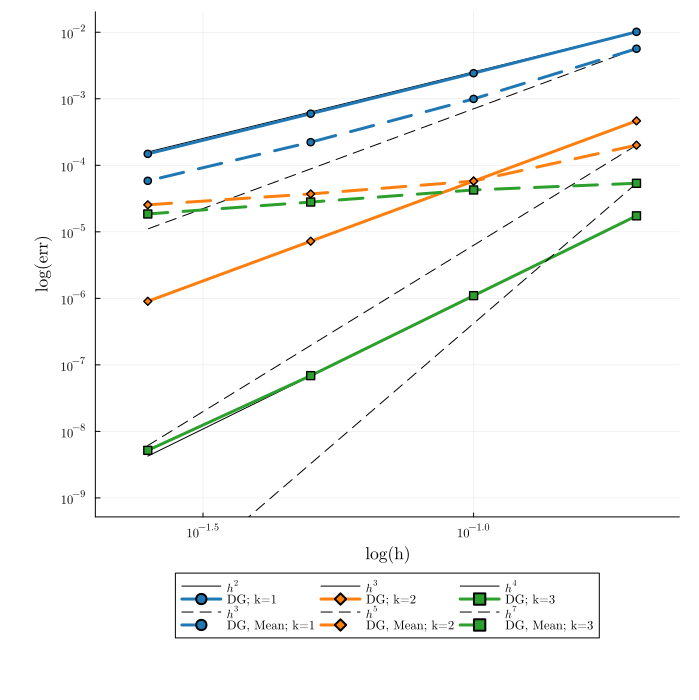

In [15]:
# Visualization of Convergence Properties
XTick = [10.0^(ll) for ll=1:-0.5:-2]
YTick = [10.0^(ll) for ll=1:-1:-12]
colors = palette(:tab10)
markers = [:circ :diamond :square]

yMax =  2*maximum([err;err_Gibbs])
yMin = 0.1*minimum([err;err_Gibbs])

xMax = 1.2*maximum(h_ref)
xMin = 0.8*minimum(h_ref)

xs = [10e-1 maximum(h_ref)]

plt = Plots.plot(yscale=:log10, 
                        yticks=YTick, 
                        ylims=(yMin, yMax),
                        xscale=:log10, 
                        xticks=XTick, 
                        xlims=(xMin, xMax),
                        xlabel="log(h)",
                        ylabel="log(err)")

for k = 1:pMax
    c1 =  (err[1,k]/h_ref[1]^(k+1)) # Constant to adjust the reference line
    Plots.plot!(h_ref[:], t-> c1*t^(k+1), color=:black, label=latexstring(" h^{$(k+1)}"))
end
for k = 1:pMax
    Plots.plot!(h_ref[:], err[:,k], color=colors[k], lw=3, marker=markers[k],label=@sprintf("DG; k=%d",k))
end

for k = 1:pMax
    c2 =  (err_Gibbs[1,k]/h_ref[1]^(2k+1)) # Constant to adjust the reference line
    Plots.plot!(h_ref[:], t->c2*t^(2k+1), color=:black, ls=:dash,label=latexstring(" h^{$(2k+1)}"))
end
for k = 1:pMax
    Plots.plot!(h_ref[:], err_Gibbs[:,k], color=colors[k], lw=3, ls=:dash, marker=markers[k], label=@sprintf("DG, Mean; k=%d",k))
end


FIG = Plots.plot(plt,
        fontfamily=plot_font, 
        legend=:outerbottom,
        size=(700,700), 
        left_margin=8mm,
        right_margin=3mm,
        bottom_margin=1mm,
        legend_columns=3) 
Plots.pdf(FIG,joinpath(results_dir, "Convergence_SIAC_T1_Gibbs4"))
# Display the plot
display(FIG)

### Post-processing: check errors and order of convergence

In [16]:
# check results stored before
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r") do file
    println("Variables stored in the file:")
    println(keys(file))
end

Variables stored in the file:
["uh_ev_final", "uh_Nodal_final", "uh_ev_final_pp", "h_ref", "err", "err_pp", "fx_BCD", "err_BCD", "fx_Gibbs_mean4", "err_Gibbs4"]


In [17]:
# Load results
@load joinpath(results_dir, "results_DG_T1.jld2") h_ref err_Gibbs4

2-element Vector{Symbol}:
 :h_ref
 :err_Gibbs4

In [18]:
refine = 4

4

In [19]:
println("Errors for p=1:")
for m in 1:refine
    println("m=$m, h=$(h_ref[m]): err=$(err_Gibbs4[m, 1])")
end

Errors for p=1:
m=1, h=0.19999999999999996: err=0.005655557319984357
m=2, h=0.09999999999999998: err=0.0009955989981512271
m=3, h=0.050000000000000044: err=0.00022275949771019765
m=4, h=0.025000000000000022: err=5.845887380883957e-5


In [20]:
orders = zeros(refine-1)
for m in 1:refine-1
    e1, e2 = err_Gibbs4[m,1], err_Gibbs4[m+1,1]
    h1, h2 = h_ref[m], h_ref[m+1]
    orders[m] = log(e1/e2) / log(h1/h2)
end

In [21]:
println("\nEstimated orders of convergence (between consecutive mesh refinements):")
for m in 1:refine-1
    println("Between m=$m and m=$(m+1): order=$(orders[m])")
end


Estimated orders of convergence (between consecutive mesh refinements):
Between m=1 and m=2: order=2.506032516159238
Between m=2 and m=3: order=2.1600778338815037
Between m=3 and m=4: order=1.929993003212442
